#### Mounting Drive to access data (Uncomment if using Google colab)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive' , force_remount = True)
# intra_annotated_file = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/combined_annotated.csv"
# features_file = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/AE_features.csv"

#### Comment Out if using google colab

In [2]:
from imported_files.paths_n_vars import intra_annotated_file, features_file

#### Import TensorFlow and other libraries


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%pip install tensorflow --quiet
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import time
import functools

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

Note: you may need to restart the kernel to use updated packages.

Num GPUs Available:  0


Parameters

In [4]:
rand_state = 54
test_fraction = 0.1

latent_dim = 40
activation_func = 'sigmoid'
optimizer = 'adam'
num_epochs = 100
batch_size = 32

save_model = True

User defined functions

In [5]:
def plot_signal(x ,y , x_label = "" , y_label = "" , title = ""):
    plt.grid(True)
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def timeit(function):
    @functools.wraps(function)
    def wrapper_timeit(*arg , **kwargs):
        
        start = time.perf_counter()
        function_output = function(*arg , **kwargs)
        end = time.perf_counter()
        print(f"{function.__name__} took : {end - start : 0.2f} seconds")
        
        return function_output
    
    return wrapper_timeit

# scale data
@timeit
def MyMinMaxScaler(dataframe):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    return (dataframe - dataframe.min())/(dataframe.max() - dataframe.min())

#### Load the dataset

In [6]:
annotated_data = pd.read_csv(intra_annotated_file)
labels = annotated_data.iloc[0] # this will exract the annotation 2nd row
print(f"segments : labels \n{labels}")
raw_segments = (annotated_data.iloc[1 : , ])
print(f"raw_data = {raw_segments}")

assert not np.any(np.isnan(raw_segments))

segments : labels 
0_1     0.0
0_2     0.0
0_3     0.0
0_4     0.0
0_5     0.0
       ... 
9_64    1.0
9_74    1.0
9_78    1.0
9_95    1.0
9_96    1.0
Name: 0, Length: 6669, dtype: float64
raw_data =            0_1       0_2       0_3       0_4       0_5       0_6       0_7  \
1    -0.041815  0.219870 -0.073337  0.174313  0.008353 -0.063914 -0.052148   
2    -0.043789  0.222160 -0.079727  0.188834  0.007409 -0.037660 -0.055700   
3    -0.045800  0.221264 -0.086917  0.200428  0.006388 -0.010793 -0.058342   
4    -0.047832  0.217293 -0.094864  0.208929  0.005141  0.016216 -0.060265   
5    -0.049867  0.210421 -0.103500  0.214245  0.003538  0.042878 -0.061669   
...        ...       ...       ...       ...       ...       ...       ...   
1246 -0.046270 -0.122461  0.032764 -0.138325  0.140099 -0.126210  0.197311   
1247 -0.053644 -0.112103  0.015662 -0.143542  0.123514 -0.134732  0.178520   
1248 -0.059602 -0.098977 -0.000377 -0.147536  0.105705 -0.143063  0.158841   
1249 -0.064253 -0.08

MyMinMaxScaler took :  0.18 seconds
Scaled data shape = (1250, 6669)


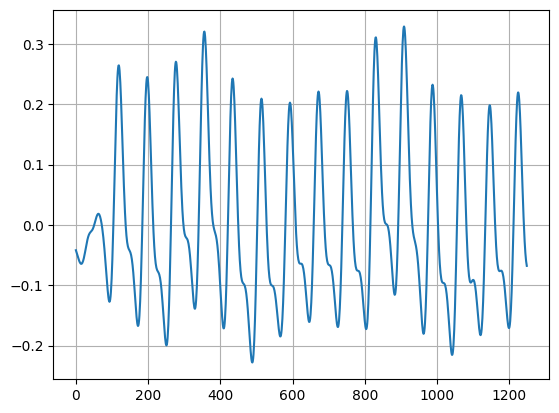

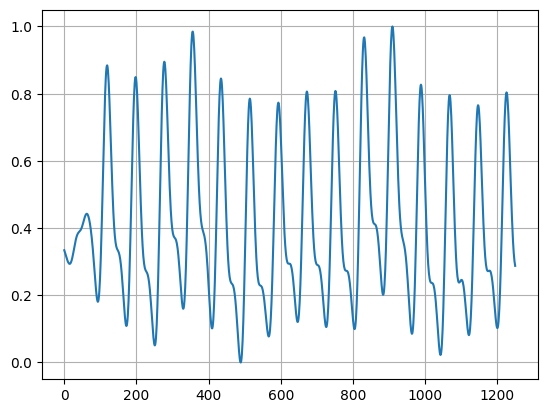

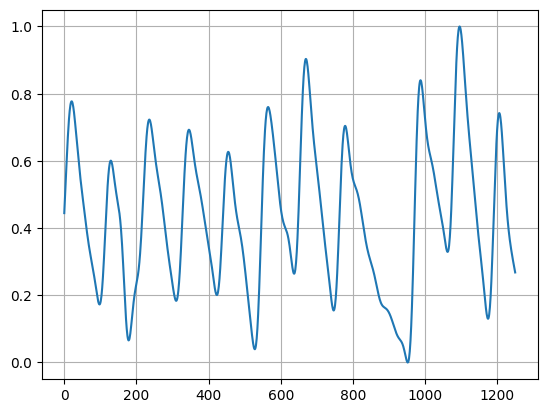

scaled_data = 
[[0.33407892 0.78713794 0.27347693 ... 0.59742796 0.65208976 0.77350493]
 [0.33053396 0.79127939 0.26241782 ... 0.6188475  0.64576106 0.77041569]
 [0.32692294 0.78966001 0.24997511 ... 0.63909147 0.63786738 0.76551806]
 ...
 [0.30214272 0.21048138 0.39974853 ... 0.51267065 0.56032156 0.65202177]
 [0.29379214 0.23915499 0.37414097 ... 0.5247084  0.53878947 0.64788497]
 [0.28754702 0.2725664  0.35091166 ... 0.53576908 0.51724711 0.63982856]]


In [7]:
# %%timeit

scaled_data = MyMinMaxScaler(raw_segments).values
print(f"Scaled data shape = {scaled_data.shape}")
plot_signal(range(len(raw_segments["0_1"])) , raw_segments["0_1"])
plot_signal(range(len(scaled_data[ : , 0])) , scaled_data[ : , 0])

# split the dataset using test_train_split() function
x_train, x_test, y_train, y_test = train_test_split(scaled_data.T , labels, test_size = test_fraction, random_state = rand_state, stratify = labels)

plot_signal(range(len(x_train[0])) , x_train[0])

print(f"scaled_data = \n{scaled_data}")

assert not np.any(np.isnan(scaled_data)) , "There are nan values in scaled Data"

**Basic autoencoder**

#### Simplified Autoencoder

In [16]:
class Autoencoder(Model):
    def __init__(self, latent_dim, num_samples, activation_function):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
              layers.Flatten(),
              layers.Dense(latent_dim, activation='tanh' , name = "Encoder"),
            ])
        self.decoder = tf.keras.Sequential([
              layers.Dense(num_samples, activation=activation_function , name = "Decoder"),
            ])
        
        # self.encoder = tf.keras.Sequential([
        #       layers.Flatten(),
        #       layers.Dense(int(num_samples/2) , activation = activation_func , name = "Encoder_in"), 
        #       layers.Dense(latent_dim, activation='tanh' , name = "Coded_representation"),
        #     ])
        # self.decoder = tf.keras.Sequential([
        #       layers.Dense(int(num_samples/2) , activation = activation_func , name = "Decoder_in"),
        #       layers.Dense(num_samples, activation=activation_function , name = "Decoded_output"),
        #     ])
        
    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

num_samples = x_test.shape[1]

autoencoder = Autoencoder(latent_dim, num_samples, activation_func)

autoencoder.compile(optimizer = optimizer, loss = losses.MeanSquaredError(), metrics = ['mae'])

tf.debugging.set_log_device_placement(True)

# configure early stopping
es = EarlyStopping(monitor='val_mae', patience=5)

with tf.device('/device:GPU:0'):
  autoencoder.fit(x_train, x_train,
                epochs = num_epochs,
                shuffle = True,
                batch_size = batch_size,
                validation_data = (x_test, x_test),
                callbacks = [es])

Epoch 1/100
188/188 [==============================] - 2s 5ms/step - loss: 0.0429 - mae: 0.1709 - val_loss: 0.0314 - val_mae: 0.1450
Epoch 2/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0268 - mae: 0.1332 - val_loss: 0.0242 - val_mae: 0.1262
Epoch 3/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0218 - mae: 0.1194 - val_loss: 0.0205 - val_mae: 0.1160
Epoch 4/100
188/188 [==============================] - 1s 5ms/step - loss: 0.0189 - mae: 0.1110 - val_loss: 0.0183 - val_mae: 0.1090
Epoch 5/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0170 - mae: 0.1048 - val_loss: 0.0172 - val_mae: 0.1056
Epoch 6/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0154 - mae: 0.0993 - val_loss: 0.0151 - val_mae: 0.0983
Epoch 7/100
188/188 [==============================] - 1s 4ms/step - loss: 0.0140 - mae: 0.0943 - val_loss: 0.0140 - val_mae: 0.0942
Epoch 8/100
188/188 [==============================] - 1s 3ms/step - 

#### Testing the trained autoencoder

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 1250)              0         
                                                                 
 Encoder (Dense)             (None, 40)                50040     
                                                                 
Total params: 50040 (195.47 KB)
Trainable params: 50040 (195.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


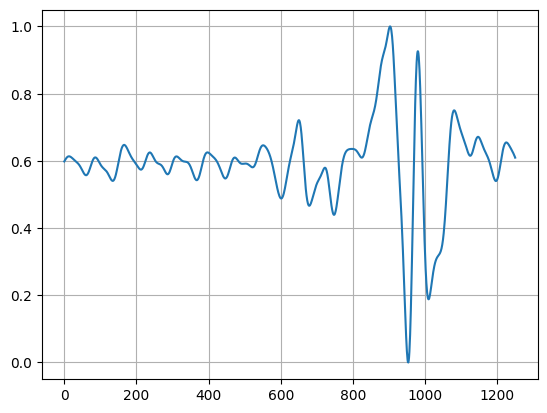

[0.59825921 0.60018722 0.60208542 ... 0.61518595 0.61250129 0.6096587 ]
range(0, 1250)
tf.Tensor([[0.58846915 0.59185016 0.5956725  ... 0.6051064  0.60353684 0.6024264 ]], shape=(1, 1250), dtype=float32)


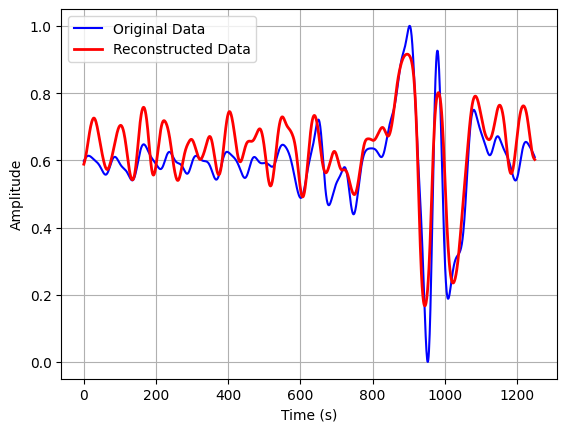

In [17]:
autoencoder.encoder.summary()
# plot_model(autoencoder, 'model.png', show_shapes=True)
segment = x_test[39]
# segment = segment  # Reshape the segment to match the autoencoder input shape
plot_signal(range(len(segment)),segment)
print(segment)
t = range(len(segment) )
print(t)
reconstructed_seg = autoencoder(tf.reshape(segment , [1,1250]))
print(reconstructed_seg)
plt.figure()
plt.plot(t, segment, 'b-', label='Original Data')
plt.plot(t, np.array(reconstructed_seg).reshape(1250,1), 'r-', linewidth = 2, label='Reconstructed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#### Save the model

In [10]:
# save model to file
if save_model:
    autoencoder.encoder.save('model.h5')

f:\Shwashwat\B_Tech_ECE\project\codes\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Extract and save features

In [45]:
def encode_data(array):
    temp = []
    for i in range(array.shape[1]):
        encoded = autoencoder.encoder(tf.reshape(array[ : , i] , [1,1250]))
        temp.append(encoded.numpy()[0])
    return pd.DataFrame(data = temp)
# print(type(scaled_data))
print(scaled_data.shape)
# print(len(scaled_data))
AE_features = encode_data(scaled_data)
AE_features.to_csv("AE_Features.csv" , index=False)

(1250, 6669)


##### Concat with other features

In [49]:
features_df = pd.read_csv(features_file)
AE_features = pd.read_csv("AE_Features.csv")
all_features_df = pd.concat([features_df , AE_features] , axis = 1)
print(all_features_df)
all_features_df.to_csv(features_file.split('/')[0] + '/' + "all_features.csv" , index=False)

      population_std  sample_std  skewness  kurtosis  permutation_entropy  \
0           0.133277    0.133330  0.606695 -0.665910             4.637378   
1           0.140442    0.140498  0.634264 -0.711030             4.717880   
2           0.141026    0.141083  0.583467 -0.763156             4.719789   
3           0.142367    0.142424  0.558730 -0.771037             4.701631   
4           0.144961    0.145019  0.568602 -0.724176             4.733015   
...              ...         ...       ...       ...                  ...   
6664        0.156740    0.156802  1.209374  2.031246             3.293623   
6665        0.185325    0.185399  0.013685 -0.283116             3.951962   
6666        0.181930    0.182003 -0.494901  0.748957             3.900135   
6667        0.152055    0.152116 -0.664218  0.598133             3.888173   
6668        0.134963    0.135017 -1.071912  1.879843             3.614196   

      svd_entropy      mean       rms  interquartile_range  shannon_entropy